In [2]:
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.read_csv('data/cleaned_data.csv')

In [6]:
data.describe()
data.info()

,StateCodeFIPS,MunicipalCodeFIPS,ZHVI,ZHVI_prev,Year,Month,Region Code,UnemploymentRate,#hospital,hospital_rating,private_schools_count,public_schools_count,CPI,Interest Rate,inc,inc_ineql,BD,highschool,migr,residt
count,288406.000000,288406.000000,2.884060e+05,2.884060e+05,288406.000000,288406.000000,153972.000000,153972.000000,207643.000000,207643.000000,288406.000000,288406.000000,288406.000000,287294.000000,1.263600e+05,126360.000000,126360.000000,126360.000000,126360.000000,126360.000000
mean,29.021005,93.987618,1.701012e+05,1.695541e+05,2010.433791,6.469040,29232.380952,6.513628,2.391456,3.050638,40.209021,164.735924,219.442335,2.139067,1.149933e+07,13.447881,23.188338,85.644084,34.294872,226.649036
std,15.394842,106.077221,1.280370e+05,1.274742e+05,6.257606,3.426564,15440.705399,3.007321,3.150629,0.636859,69.414517,242.398566,27.515192,1.838378,3.002911e+07,3.297132,10.778295,6.040965,5580.516090,530.849851
min,1.000000,1.000000,2.745000e+04,2.733300e+04,2000.000000,1.000000,1001.000000,1.300000,1.000000,1.000000,0.000000,0.000000,170.000000,0.250000,5.683000e+04,6.355878,3.200000,59.900000,-115651.000000,2.254000
25%,13.000000,29.000000,9.223425e+04,9.202325e+04,2005.000000,3.000000,13220.500000,4.300000,1.000000,3.000000,2.000000,19.000000,194.900000,0.750000,9.277700e+05,11.369811,14.700000,81.800000,-464.000000,26.422000
50%,32.000000,71.000000,1.341245e+05,1.337580e+05,2010.000000,6.000000,33010.000000,5.800000,1.000000,3.000000,12.000000,63.000000,220.472000,1.250000,2.412484e+06,12.868346,20.500000,86.800000,54.000000,63.051500
75%,41.000000,121.000000,2.045488e+05,2.038700e+05,2016.000000,9.000000,41033.500000,8.200000,2.000000,3.500000,45.000000,191.000000,239.557000,3.000000,8.944138e+06,14.733427,29.900000,90.200000,774.000000,205.803000
max,55.000000,810.000000,1.908712e+06,1.852198e+06,2021.000000,12.000000,55133.000000,36.000000,46.000000,5.000000,449.000000,1415.000000,274.138000,6.250000,6.534829e+08,45.411853,75.300000,98.100000,44753.000000,10094.865000


## Correlations of Features

In [56]:
pearson = data.corr(method="pearson").ZHVI_next
spearman = data.corr(method="spearman").ZHVI_next
corr = pd.concat([pearson, spearman], axis=1)
corr.columns = ['pearson', 'spearman']
corr

,pearson,spearman
StateCodeFIPS,-0.059253,-0.015850
MunicipalCodeFIPS,-0.175081,-0.215634
ZHVI,0.993012,0.994286
ZHVI_prev,0.992870,0.994133
Year,0.160586,0.174982
Month,0.006784,0.007612
UnemploymentRate,-0.269533,-0.347133
#hospital,0.260032,0.370594
hospital_rating,0.035882,0.071445
private_schools_count,0.138903,0.335045


## Feature Importance

Feature: Year, Score: 0.00930
Feature: Month, Score: 0.00067
Feature: UnemploymentRate, Score: 0.00511
Feature: #hospital, Score: 0.02832
Feature: hospital_rating, Score: 0.04670
Feature: private_schools_count, Score: 0.03323
Feature: public_schools_count, Score: 0.09756
Feature: CPI, Score: 0.01998
Feature: Interest Rate, Score: 0.00318
Feature: inc, Score: 0.07771
Feature: inc_ineql, Score: 0.03774
Feature: BD, Score: 0.53398
Feature: highschool, Score: 0.04398
Feature: migr, Score: 0.02577
Feature: residt, Score: 0.03678
                        0         1
1                   Month  0.000674
8           Interest Rate  0.003175
2        UnemploymentRate  0.005106
0                    Year  0.009301
7                     CPI  0.019979
13                   migr  0.025770
3               #hospital  0.028321
5   private_schools_count  0.033227
14                 residt  0.036783
10              inc_ineql  0.037741
12             highschool  0.043981
4         hospital_rating  0.046696
9 

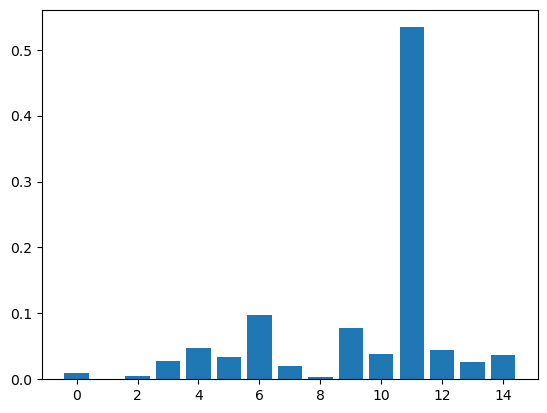

In [87]:
# results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. 
# so run the model a few times and compare the average outcome.

from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

X = data.loc[:,~data.columns.isin(['ZHVI_next','ZHVI','ZHVI_prev','County','State','Date','MunicipalCodeFIPS','StateCodeFIPS'])]
y = data.ZHVI_next

importance = []
for i in range(10):
    model = DecisionTreeRegressor()
    model.fit(X, y)
    coef = model.feature_importances_
    importance.append(coef)
avg_importance = np.mean(importance, axis=0)

a=[]
# summarize feature importance
for i,v in enumerate(avg_importance):
    a.append([X.columns[i],v])
    print('Feature: %s, Score: %.5f' % (X.columns[i],v))
   
a = pd.DataFrame(a)
print(a.sort_values(by=1))
# plot feature importance
plt.bar([x for x in range(len(avg_importance))], avg_importance)
plt.show()


#### exclude BD ####
# X = data.loc[:,~data.columns.isin(['ZHVI_next','ZHVI','ZHVI_prev','County','State','Date','BD'])]
# y = data.ZHVI_next
# importance = []
# for i in range(10):
#     model = DecisionTreeRegressor()
#     model.fit(X, y)
#     coef = model.feature_importances_
#     importance.append(coef)
# avg_importance = np.mean(importance, axis=0)

# # summarize feature importance
# for i,v in enumerate(avg_importance):
# 	print('Feature: %s, Score: %.5f' % (X.columns[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(avg_importance))], avg_importance)
# plt.show()

In [88]:
a.sort_values(by=1, ascending=False)

,0,1
11,BD,0.533982
6,public_schools_count,0.097557
9,inc,0.077707
4,hospital_rating,0.046696
12,highschool,0.043981
10,inc_ineql,0.037741
14,residt,0.036783
5,private_schools_count,0.033227
3,#hospital,0.028321
13,migr,0.025770
